In [233]:
from google.colab import drive
import numpy as np
from scipy.linalg import circulant
import matplotlib.pyplot as plt
import time

In [33]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
f = open('/content/drive/My Drive/pim.txt')
pim = f.readline()
pim = pim.split('\t')
pim = np.array(list(map(lambda x: float(x), pim)))
f.close()
f = open('/content/drive/My Drive/nf.txt')
nf = f.readline()
nf = nf.split('\t')
nf = np.array(list(map(lambda x: float(x), nf)))
f.close()
f = open('/content/drive/My Drive/u1.txt')
u1 = f.readline()
u1 = u1.split('\t')
u1 = np.array(list(map(lambda x: float(x), u1)))
f.close()

In [183]:
K = 10
L = 900
N = 900

In [184]:
m1 = pim[:N].reshape((N,1))
m2 = u1[:N].reshape((N,1))

In [185]:
def snr(sig, noise,dt=1e-4):
    Signal = np.sum(np.abs(np.fft.fft(sig)*dt)**2)/len(np.fft.fft(sig))
    Noise = np.sum(np.abs(np.fft.fft(noise)*dt)**2)/len(np.fft.fft(noise))
    return (10 * np.log10(Signal/Noise))


In [186]:

C = np.random.randn(L,N)




B = np.random.randn(L,K) 

In [241]:
h1 = np.random.randn(K,1) 
h2 = np.random.randn(K,1) 
h3 = np.random.randn(K,1)
h4 = np.random.randn(K,1)

In [242]:
A = circulant(C[:,0]) @ B
for iter in range(1,N):
    elem = circulant(C[:,iter]) @ B
    A = np.hstack((A,elem))

In [243]:

X11 = h1 @ m1.reshape((1,N))
X12 = h2 @ m1.reshape((1,N))

X1 = np.vstack((X11,X12))

X21 = h3 @ m2.reshape((1,N))
X22 = h4 @ m2.reshape((1,N))

X2 = np.vstack((X21,X22))

In [244]:
a, b = A.shape
A0 = np.zeros((a,b))
A1 = np.hstack((A,A0))
A2 = np.hstack((A0,A))
A = np.vstack((A1,A2))

In [245]:
y1 = A @ X1.reshape((2*N*K,1))

In [246]:
y2 = A @ X2.reshape((2*N*K,1))

In [249]:
snr(y1[:L],1000*nf[:L].reshape((L,1)))

26.33749587721349

In [250]:
snr(y1[L:],1000*nf[L:2*L].reshape((L,1)))

28.340802142407604

In [251]:
snr(y2[:L],1000*nf[:L].reshape((L,1)))

12.105506743230237

In [252]:
snr(y2[L:],1000*nf[L:2*L].reshape((L,1)))

11.343564670846211

In [253]:
y = y1 + y2 + 1000*nf[:2*L].reshape((2*L,1))

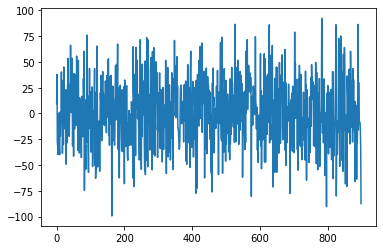

In [254]:
plt.plot(y[:N])

In [231]:

def prox_nuclear(A, lambd):
    U, S, Vh = np.linalg.svd(A)
    svp = np.sum(S > lambd)
    if svp >= 1:
        S = S[:svp] - lambd
        X = U[:,:svp] @ np.diag(S) @ Vh[:svp]
        nucnorm = np.sum(S)
    else:
        X = np.zeros(A.shape)
        nucnorm = 0
    return X, nucnorm

In [232]:
def prox_l21(A,lambd):
    X = np.zeros(A.shape)
    for i in range(X.shape[1]):
        nxi = np.linalg.norm(A[:,i])
        if nxi > lambd:
            X[:,i] = (1 - lambd/nxi) * A[:,i]
    return X
    

In [234]:
def lrr(y, A, lambd):
    tol = 6e-4
    max_iter = 500
    ro = 1.1
    mu = 1e-4
    max_mu = 1e10

    d, na = y.shape
    a, nb = A.shape
    #X = np.zeros((nb, na))
    X = np.zeros((2*K,N))
    E = np.zeros((d, na))
    J = X

    Y1 = E
    Y2 = X
   
    Ablock = A[:int(a/2),:int(nb/2)]

    AtA = Ablock.T @ Ablock
    Aty = A.T @ y
    I = np.eye(int(nb/2))
    invAtAIblock = np.linalg.inv(AtA + I)
    zeros = np.zeros((int(nb/2),int(nb/2)))
   # print(invAtAIblock.shape, zeros.shape)
    invAtAI = np.vstack((np.hstack((invAtAIblock,zeros)), np.hstack((zeros,invAtAIblock))))
  
    errs = []
    times = []
    start = time.time()

    for iter in range(max_iter):
      

        J, nuclearnormJ = prox_nuclear(X+Y2/mu, 1/mu)
        E = prox_l21(y - A @ X.reshape((2*K*N,1)) + Y1/mu, lambd/mu)

        X = (invAtAI @ ((A.T @ (Y1/mu -E) + Aty).reshape((2*K,N)) - Y2/mu + J).reshape((2*K*N,1))).reshape((2*K,N))
        dY1 = y - A @ X.reshape((2*K*N,1)) - E
        dY2 = X - J

        Y1 += mu * dY1
        Y2 += mu * dY2
        mu = min(ro*mu, max_mu)
        times.append(time.time() - start)
       
        metric = np.linalg.norm(y - A @ X.reshape((2*K*N,1)))
        #print(metric)
        errs.append(metric)
        if metric < tol:
            break
    return J, E, errs, iter, times

In [255]:
Xk, E, errs, iters, times = lrr(y, A, 0.01)

In [256]:
u, s, v = np.linalg.svd(Xk)

In [257]:
s

array([9.58934895e-01, 7.62354384e-02, 4.99590323e-02, 4.22411780e-02,
       3.88038390e-02, 2.93289932e-02, 2.48653630e-02, 2.30437078e-02,
       1.74447075e-02, 1.20193511e-02, 1.13871040e-02, 8.53508856e-03,
       3.06949606e-03, 2.95594818e-04, 1.90440285e-05, 1.27114333e-05,
       6.40939512e-06, 4.15479961e-06, 2.95448536e-06, 2.52655524e-06])

In [258]:
signal1 = v[0,:]

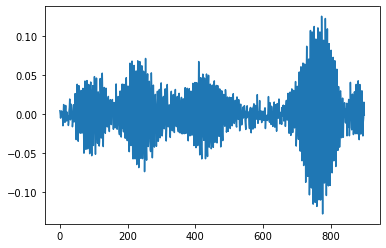

In [259]:
plt.plot(signal1)

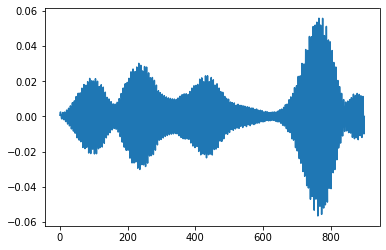

In [261]:
plt.plot(pim[:N])

In [262]:
signal2 = v[1,:]

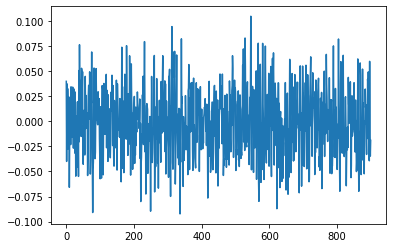

In [263]:
plt.plot(signal2)

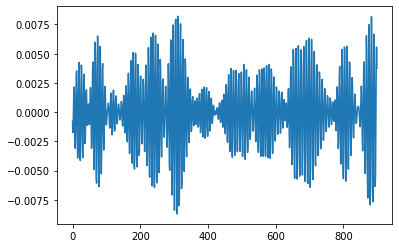

In [264]:
plt.plot(u1[:900])

In [265]:
times[-1]

200.50316381454468

In [266]:
def sae(s1, s2):
    return np.arccos((s1 @ s2) / (np.linalg.norm(s1) * np.linalg.norm(s2))) ** 2

In [269]:
sae(u1[:900], v[1,:])

1.1100431469618675

In [271]:
sae(pim[:900], -v[0,:])

0.05374343655880168